## Implementation of Gaussian Process Regression

In [1]:
import numpy as np
from numpy.linalg import inv # to invert matrices
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
def generate_data_point(x):
    """ generates data
    """
    y = np.sin(x/10.0)+(x/50.0)**2
    y += np.random.normal(0.0,0.15,size=y.shape)
    return y

In [3]:
x = np.arange(0,100,0.01)
y = generate_data_point(x)
print(len(x))

10000


In [4]:
indices = np.random.choice(range(0,len(x)),size=10000,replace=False)
train_indices = sorted(indices[:20]) # sorted data makes plotting easier
test_indices = sorted(indices[20:]) # all other indices

train_x,train_y = x[train_indices],y[train_indices]
test_x,test_y = x[test_indices],y[test_indices]

In [5]:
# to make the gaussian process equations easier to evaluate, we set E[f(x)]=0, e.g. we normalize y to have a 0-mean
mean_train = np.mean(train_y)
stdev_train = np.std(train_y)
train_y = (train_y-mean_train)/stdev_train
print(mean_train,stdev_train)

train_y = np.expand_dims(train_y,axis=-1)

1.3991426988793099 1.3668922220134663


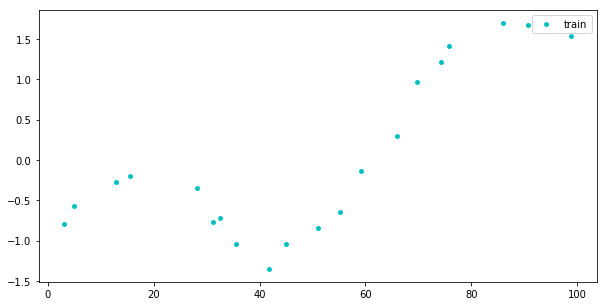

In [6]:
plt.figure(figsize=(10,5))
plt.scatter(train_x,train_y,s=15,c="c",label='train')
plt.legend()
plt.show()

### Gaussian process

$$ mean \space \mu_* = E[f_*] = K_*^T K^{-1} f $$
$$ covariance \space c_* = -K_* K^{-1} K_* + K_{**} $$

Note: computing the inverse of K is numerically unstable, so the cholesky decomposition is used in practice. The cholesky decomposition requires the matrix to be positive-definite, while the gaussian kernel (used in this implementation) guarantees only positive-semidefinite, therefore noise must first be added to the kernel covariance matrix (along the diagonal) before utilizing cholesky decomposition.

In [7]:
def evaluate_kernel(x_arr1,x_arr2,h):
    """ Evaluates kernel for two input arrays
    """
    kernel_output = []
    for x in x_arr1:
        kernel_out = np.exp(-((x-x_arr2)**2/h))
        kernel_output.append(kernel_out)
    
    return np.vstack(kernel_output)

In [32]:
h = 100
K = evaluate_kernel(train_x,train_x,h)
K_s = evaluate_kernel(x,train_x,h).T
K_ss = evaluate_kernel(x,x,h)
print(K.shape,K_s.shape,K_ss.shape)

(20, 20) (20, 10000) (10000, 10000)


In [33]:
L = np.linalg.cholesky(K+1e-6*np.eye(len(K))) # np.eye noise is required to ensure the gaussian kernel is positive-DEFINITE (NOT SEMI-definite), as cholesky requires positive-definite
print(L.shape)

(20, 20)


In [34]:
# generating the prediction means (over the entire input range)
alpha = (inv(L).T).dot(inv(L).dot(train_y))
pred_mean = (K_s.T).dot(alpha)
print(alpha.shape,pred_mean.shape)

(20, 1) (10000, 1)


In [35]:
# generating the prediction stdevs (over the entire input range)
v = inv(L).dot(K_s)
pred_cov = K_ss - ((v.T).dot(v))
pred_var = np.diagonal(pred_cov)
pred_stdev = np.sqrt(pred_var)
print(v.shape,pred_cov.shape,pred_stdev.shape)

(20, 10000) (10000, 10000) (10000,)


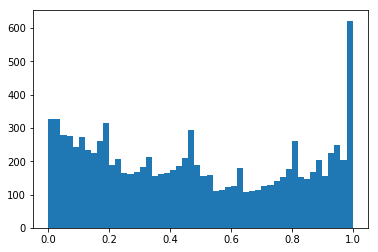

In [20]:
# h=10
plt.hist(pred_stdev,bins=50)
plt.show()

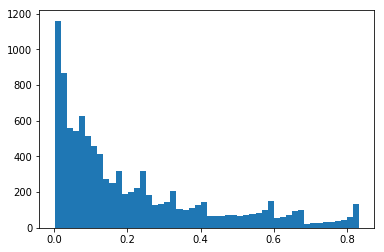

In [28]:
# h=30

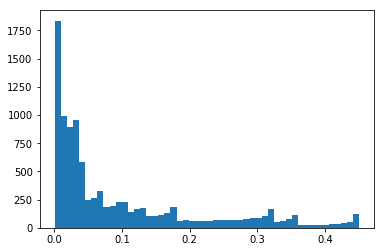

In [12]:
# h=50

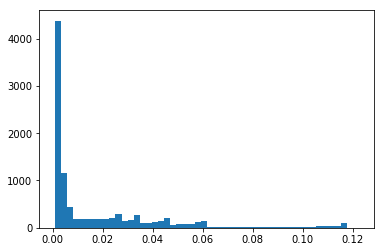

In [36]:
# h=100
plt.hist(pred_stdev,bins=50)
plt.show()

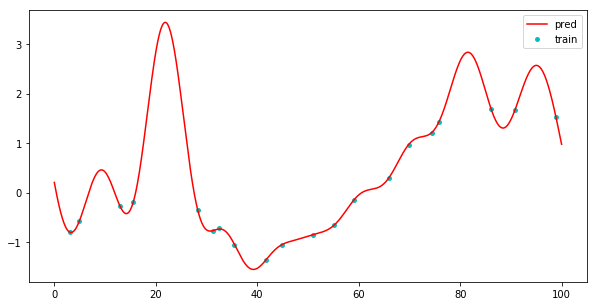

In [37]:
plt.figure(figsize=(10,5))
plt.scatter(train_x,train_y,s=15,c="c",label='train')
plt.plot(x,pred_mean,c='r',label='pred')
plt.legend()
plt.show()

In [38]:
lower_conf = pred_mean[:,0] - 2*pred_stdev
upper_conf = pred_mean[:,0] + 2*pred_stdev

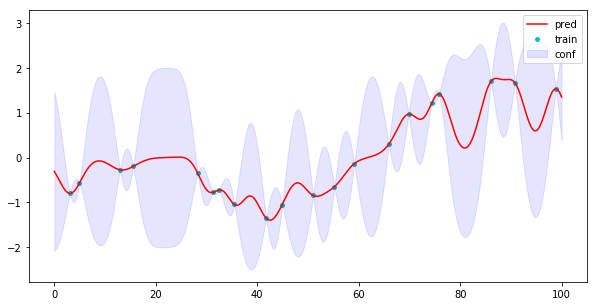

In [23]:
# plotting the prediction interval for all datapoints, h=10
fig,ax = plt.subplots()
fig.set_size_inches(10,5)
ax.scatter(train_x,train_y,s=15,c="c",label='train')
ax.plot(x,pred_mean,c='r',label='pred')
ax.fill_between(x,lower_conf,upper_conf,color='b',alpha=0.1,label='conf')
ax.legend()
plt.show()

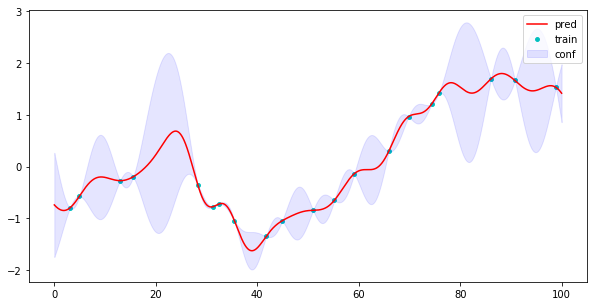

In [31]:
# h=30

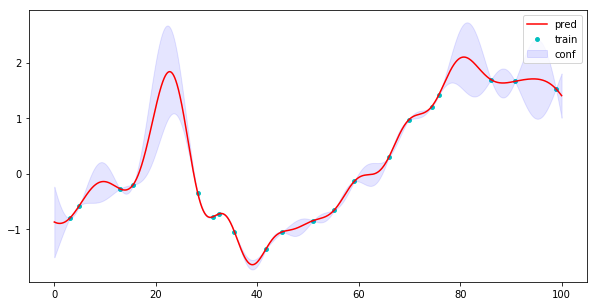

In [15]:
# h=50

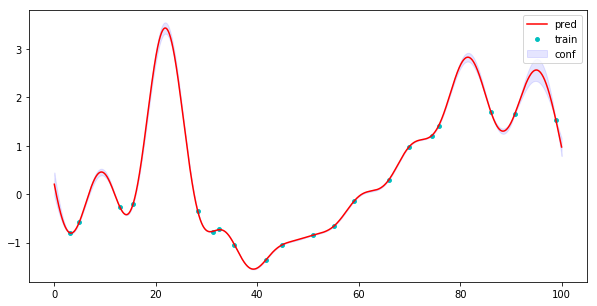

In [39]:
# h=100